<a href="https://colab.research.google.com/github/Ortimus/nvidia-numba-basics/blob/main/edge-detection-CUDA-Numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge Detection with CUDA and Numba
Demonstrates:
- 2D array operations
- Shared memory usage
- Grid/block concepts
------------------------
Haven't got this working right yet. My example image is too small to show improvements using GPU.

In [1]:
!pip install numba opencv-python
import locale
locale.getpreferredencoding()
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
import numpy as np
from numba import cuda, vectorize
import cv2
import matplotlib.pyplot as plt
from time import time


In [2]:
SOBEL_X = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)

SOBEL_Y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]], dtype=np.float32)

@cuda.jit
def edge_detect_shared(image, output):
    BLOCK_SIZE = 32
    shared = cuda.shared.array(shape=(34, 34), dtype=np.float32)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y

    x = bx * BLOCK_SIZE + tx
    y = by * BLOCK_SIZE + ty

    # Load center data
    if x < image.shape[0] and y < image.shape[1]:
        shared[ty+1, tx+1] = image[x, y]
    else:
        shared[ty+1, tx+1] = 0.0

    # Load halo regions
    if tx == 0 and x > 0:
        shared[ty+1, 0] = image[x-1, y]
    if tx == BLOCK_SIZE-1 and x < image.shape[0]-1:
        shared[ty+1, tx+2] = image[x+1, y]
    if ty == 0 and y > 0:
        shared[0, tx+1] = image[x, y-1]
    if ty == BLOCK_SIZE-1 and y < image.shape[1]-1:
        shared[ty+2, tx+1] = image[x, y+1]

    cuda.syncthreads()

    if 0 < x < image.shape[0]-1 and 0 < y < image.shape[1]-1:
        gx = gy = 0.0
        for i in range(3):
            for j in range(3):
                pixel = shared[ty+i, tx+j]
                gx += pixel * SOBEL_X[i, j]
                gy += pixel * SOBEL_Y[i, j]
        output[x, y] = (gx*gx + gy*gy)**0.5

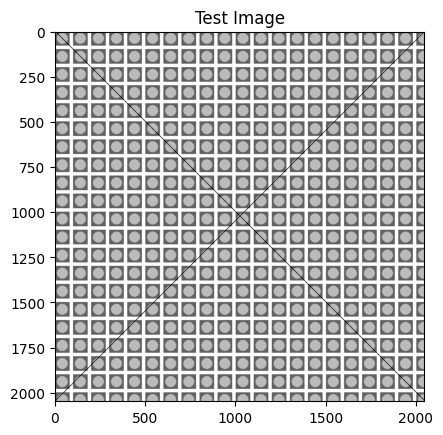

In [3]:
# Generate synthetic image
from PIL import Image, ImageDraw

# Create synthetic image with geometric shapes
def create_test_image(size=(2048, 2048)):
    img = Image.new('L', size, color=255)
    draw = ImageDraw.Draw(img)

    # Add more shapes
    for i in range(0, size[0], 100):
        for j in range(0, size[1], 100):
            draw.rectangle([i, j, i+80, j+80], fill=128)
            draw.ellipse([i+10, j+10, i+70, j+70], fill=200)

    # Add diagonal lines
    draw.line([(0, 0), size], fill=50, width=5)
    draw.line([(0, size[1]), (size[0], 0)], fill=50, width=5)

    return np.array(img).astype(np.float32) / 255

# Create and display test image
image = create_test_image()
plt.imshow(image, cmap='gray')
plt.title('Test Image')
plt.show()

In [6]:
@cuda.jit
def sobel_filter(image, output):
    x, y = cuda.grid(2)
    if x < image.shape[0]-2 and y < image.shape[1]-2:
        # Process in 2x2 blocks for better memory access
        gx = 0
        gy = 0
        for i in range(2):
            for j in range(2):
                idx = x + i
                idy = y + j
                if idx > 0 and idy > 0:
                    # Horizontal gradient
                    gx += image[idx+1, idy] - image[idx-1, idy]
                    # Vertical gradient
                    gy += image[idx, idy+1] - image[idx, idy-1]

        output[x+1, y+1] = (gx*gx + gy*gy)**0.5


def process_image(image, use_gpu=True):
    if not use_gpu:
        return cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=1)

    output = np.zeros_like(image)
    threadsperblock = (32, 32)  # Increased thread count
    blockspergrid = (
        math.ceil(image.shape[0] / threadsperblock[0]),
        math.ceil(image.shape[1] / threadsperblock[1])
    )

    # Time memory transfers
    t0 = time()
    d_image = cuda.to_device(image)
    transfer_to_gpu = time() - t0

    t0 = time()
    d_output = cuda.to_device(output)

    # Time kernel execution
    t0 = time()
    sobel_filter[(blockspergrid[0], blockspergrid[1]), threadsperblock](d_image, d_output)
    kernel_time = time() - t0

    # Time transfer back
    t0 = time()
    result = d_output.copy_to_host()
    transfer_from_gpu = time() - t0

    print(f"Transfer to GPU: {transfer_to_gpu:.4f}s")
    print(f"Kernel execution: {kernel_time:.4f}s")
    print(f"Transfer from GPU: {transfer_from_gpu:.4f}s")

    return result



Transfer to GPU: 0.0044s
Kernel execution: 0.2061s
Transfer from GPU: 0.0190s


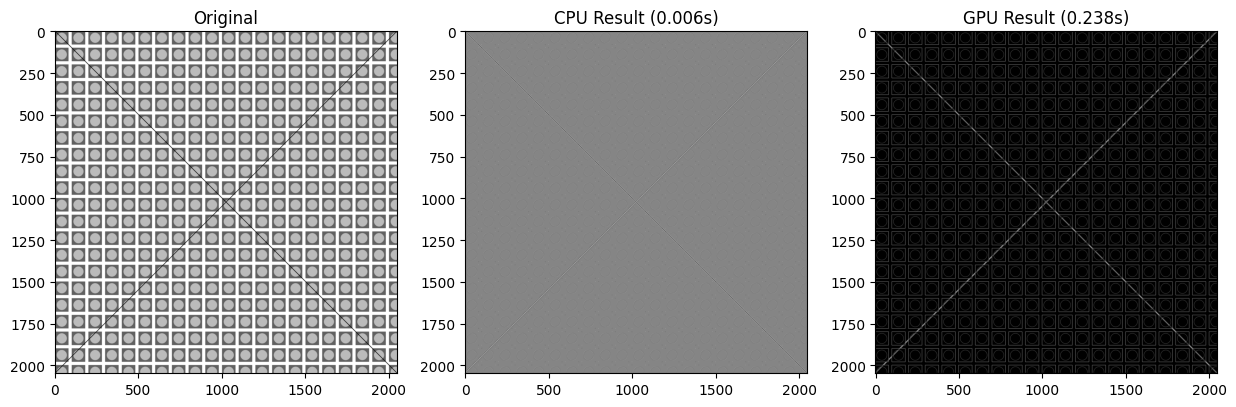

In [7]:
# Load and process test image
#image = cv2.imread('your_image.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255

import math
# CPU timing
t0 = time()
cpu_result = process_image(image, use_gpu=False)
cpu_time = time() - t0

# GPU timing
t0 = time()
gpu_result = process_image(image, use_gpu=True)
gpu_time = time() - t0

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(cpu_result, cmap='gray')
axes[1].set_title(f'CPU Result ({cpu_time:.3f}s)')
axes[2].imshow(gpu_result, cmap='gray')
axes[2].set_title(f'GPU Result ({gpu_time:.3f}s)')
plt.show()